In [103]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
import pandas as pd
import lightgbm as lgbm
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [110]:
#for getting the price change (price before tweet and price after the tweet) #5mins interval one
df2 = pd.read_csv("tweets_stocks_combined_final_60mins.csv")

df2 = df2[df2['text'].notnull()]

#creates a list of values for the y label for each row
target_value=[]
counter1 = 0
counter2 = 0
counter3 = 0


for i in range(0, len(df2)):
    
    if df2.iloc[i, 16] >= 0.020000:
        target_value.append(1)
        counter1 = 0

    elif df2.iloc[i, 16] <= -0.003393:
        target_value.append(-1)
        counter2 = 0

    else: #df2.iloc[i, 16] == 0:
        target_value.append(0)
        counter3 = 0
    
compound_group = []

for i in range(0, len(df2)):
    
    if df2.iloc[i, 12] >= 0.6:
        compound_group.append(15)
        
    elif df2.iloc[i, 12] >= 0.1:
        compound_group.append(14)
      
    elif df2.iloc[i, 12] > -0.1 and df2.iloc[i, 12] < 0.1:
        compound_group.append(13)
        
    elif df2.iloc[i, 12] <= -0.6:
        compound_group.append(11)
    
    elif df2.iloc[i, 12] <= -0.1:
        compound_group.append(12)
        
        
hours_grouped = []

for i in range(0, len(df2)):
    
    if df2.iloc[i, 8] >= 16:
        hours_grouped.append(20)
        
    elif df2.iloc[i, 8] >= 12:
        hours_grouped.append(19)
        
    else:
        hours_grouped.append(18)
      
        
#create a column for the y_label 
df2.loc[:, 'hours_grouped'] = hours_grouped
df2.loc[:,'target'] = target_value
df2.loc[:, 'compound_group'] = compound_group

df2 = df2[['topic', 'compound_group', 'hours_grouped', 'target']]

comp = pd.get_dummies(df2['compound_group'])
topic = pd.get_dummies(df2['topic'])
hrs = pd.get_dummies(df2['hours_grouped'])
# Drop column as it is now encoded
df2 = df2.drop(['compound_group'], axis = 1)
df2 = df2.drop(['topic'], axis = 1)
df2 = df2.drop(['hours_grouped'], axis = 1)
# Join the encoded df
df2 = df2.join(comp)
df2 = df2.join(topic)
df2 = df2.join(hrs)

X = df2.iloc[:, 1:]
y = df2.target
class_labels = [-1, 0, 1]
y = y.apply(lambda x: class_labels.index(x))

#Train-test split
#test size is 20% of the dataset
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=1)

smote = SMOTE(random_state=0, sampling_strategy='minority')
X_train, y_train = smote.fit_sample(X_train, y_train)

## GridSearchCV Hyperparameter Tuning

In [ ]:
def create_model(optimizer, activation, dropout_rate, neurons1, neurons2):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=len(X_train.columns), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation=activation))
    model.add(Dense(3))
    # Compile model
    model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=50)
# define the grid search parameters
optimizer = ['SGD', 'Adam']
activation = ['softmax', 'relu', 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1, 0.2]
neurons1 = [8, 16, 32]
neurons2 = [8, 16, 32]
param_grid = dict(optimizer=optimizer, activation=activation, dropout_rate=dropout_rate, neurons1=neurons1, neurons2=neurons2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1_micro', verbose=2)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

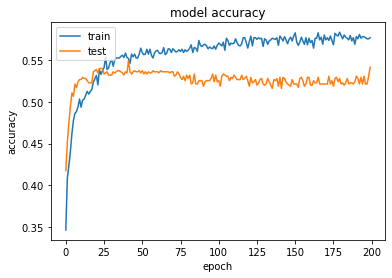

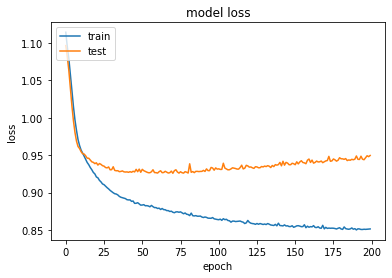

In [47]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
y_pred = model.predict_classes(X_test)

In [63]:
y_pred

array([0, 2, 2, ..., 1, 1, 1], dtype=int64)

In [64]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  0   1   2]
 [164 666 293]]


In [71]:
confusion_matrix(y_test, y_pred)

array([[ 62, 148, 109],
       [ 21, 362,  14],
       [ 81, 156, 170]], dtype=int64)

In [73]:
metrics.f1_score(y_test, y_pred, average='weighted')

0.4897376859606557